In [72]:
import os
import numpy as np
import pandas as pd

import mlflow
from mlflow import MlflowClient
from mlflow.entities import ViewType

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# %matplotlib widget
%matplotlib inline

In [38]:
tracking_uri = os.path.expanduser('~/mlruns/')
mlflow.set_tracking_uri(tracking_uri)
experiment_name = os.path.basename(os.getcwd())

In [46]:
experiment_name = 'MeritFed-M'

In [132]:
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = mlflow.search_runs(experiment_names=[experiment_name],
# runs = mlflow.search_runs(experiment_ids=e.experiment_id,
                          # # filter_string=query,
                          # filter_string='',
                          output_format='list',
                          run_view_type=ViewType.ACTIVE_ONLY)


In [65]:
runs.dropna()
runs['metrics.accuracy'] 

0     0.968916
1     0.928987
2     0.969169
3     0.943139
4     0.967400
5     0.921152
6     0.967652
7     0.943139
8     0.956280
9     0.955775
10    0.902957
11    0.943139
12    0.945773
13    0.898940
14    0.946019
15    0.919645
16    0.962534
17    0.915948
18    0.962287
19    0.919645
20    0.971407
21    0.921124
22    0.971654
23    0.919645
Name: metrics.accuracy, dtype: float64

In [133]:
metric_key = 'loss'
df = list()
for r in runs:
    r_id=r.info.run_id
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')
    history = client.get_metric_history(run_id=r_id, key=metric_key)
    history = [dict(e, **config) for e in history]
    # history = [dict(e, **{'run_id': r_id}) for e in history]
    # history.add(
    df.append(pd.DataFrame.from_dict(history))
df = pd.concat(df).reset_index(drop=True)
df.head(-100)

,key,step,timestamp,value,n_iters,n_peers,seed,model,loss,dataset,n_samples,h_ratio,mu_normal,optimizer,batch_size,lr,true_weights,md_n_iters_,md_full_,md_lr_
0,loss,0,1697377690742,1.604056,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",200,0.99,None,"{'name': 'MeritFed', 'id': 1}",20,0.01,None,20,False,0.05
1,loss,50,1697377693038,0.896400,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",200,0.99,None,"{'name': 'MeritFed', 'id': 1}",20,0.01,None,20,False,0.05
2,loss,101,1697377693797,0.614043,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",200,0.99,None,"{'name': 'MeritFed', 'id': 1}",20,0.01,None,20,False,0.05
3,loss,151,1697377694550,0.491564,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",200,0.99,None,"{'name': 'MeritFed', 'id': 1}",20,0.01,None,20,False,0.05
4,loss,202,1697377695303,0.423449,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",200,0.99,None,"{'name': 'MeritFed', 'id': 1}",20,0.01,None,20,False,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,loss,4797,1697373868338,0.094498,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",100,0.99,None,"{'name': 'MeritFed', 'id': 1}",10,0.01,None,20,True,0.05
2296,loss,4848,1697373868984,0.094360,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",100,0.99,None,"{'name': 'MeritFed', 'id': 1}",10,0.01,None,20,True,0.05
2297,loss,4898,1697373869607,0.094004,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",100,0.99,None,"{'name': 'MeritFed', 'id': 1}",10,0.01,None,20,True,0.05
2298,loss,4949,1697373870234,0.093789,5000,20,0,"{'name': 'Linear', 'id': 0}","{'name': 'CrossEntropy', 'id': 1}","{'name': 'MNIST', 'id': 1}",100,0.99,None,"{'name': 'MeritFed', 'id': 1}",10,0.01,None,20,True,0.05


AttributeError: module 'seaborn' has no attribute 'show'

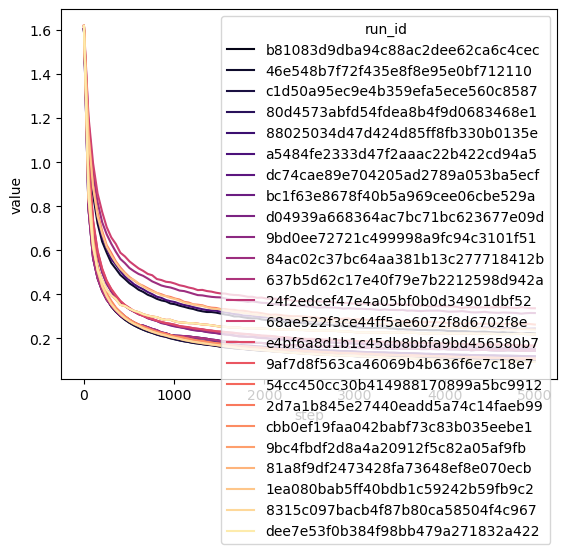

In [130]:
import seaborn as sns
sns.lineplot(data=df, x='step', y='value', palette="magma", hue='run_id')
sns.lineplot(data=df, x='timestamp', y='value', palette="magma", hue='run_id')

In [ ]:
def plot1(worker_steps, reg, adv_strength, mode):
    df = train_exp_df if mode == "train" else valid_exp_df
    plot_df = df[(df["worker_steps"] == worker_steps) & 
                 (df["reg"] == reg) & 
                 (df["adv_strength"] == adv_strength)]
    for metric in metrics:
        plt.figure()
        sns.lineplot(data=plot_df,
            x="E", y=metric, hue="adv_reg", palette="magma", hue_norm=LogNorm(), style="attack", style_order=["NA", "LF", "ALIE"])
        plt.title(f"Adversarial MNIST, {mode}, {metric}, {worker_steps} steps, reg = {reg}")
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        # plt.yscale("log")
        plt.savefig(f"outputs/adv_{metric}_wstep{worker_steps}_reg{reg}_{mode}.pdf")

In [11]:
# del mcolors.TABLEAU_COLORS['tab:pink']
colors = list(mcolors.TABLEAU_COLORS.keys())
markers = ['o', '<', '>', 'v', 's', 'D', '*']

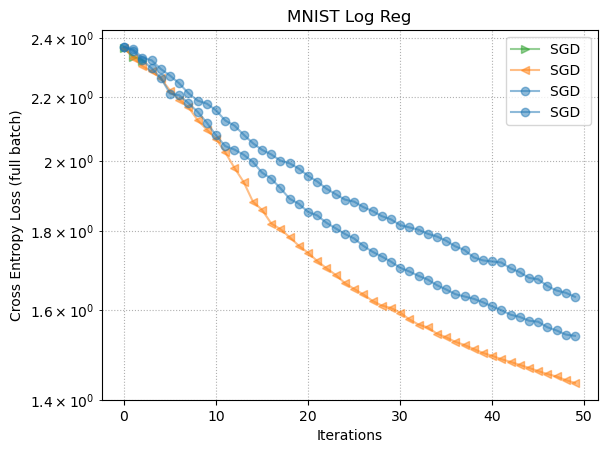

In [17]:
label_key = 'optimizer'
metric_key = 'loss'
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

optimizer_names = ['SGD']
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

    # if config['batch_size'] != 4:
    #     continue
    title = 'MNIST Log Reg | batch_size=' + str(config['batch_size'])
    beg = 0
    end = 120000

    # label = config[label_key]['name'] + ' ' + r.data.params['Title']
    add = 0
    if config['md_full_'] is not None:
        add = int(config['md_full_'])
    i = config[label_key]['id'] + add
    history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
    y = np.array([h.value for h in history])
    x = np.array([h.timestamp for h in history])
    x = np.array([h.step for h in history])
    mask = (x >= beg)*(x <= end)
    x, y = x[mask], y[mask]

    plt.plot(x, y,
             alpha=0.5, color=colors[i],
             marker=markers[i], markevery=1,
             label=label)

    # print()
# title = '%s, bs=%i' % (an, bs)
title = 'MNIST Log Reg'
plt.title(title)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss (full batch)')
plt.yscale('log')
plt.xscale('linear')
plt.grid(True, which="both", ls='dotted')
plt.legend()
plt.savefig('figures/'+ title +'.pdf', bbox_inches='tight')
# plt.savefig(title +'.pdf', bbox_inches='tight')
plt.show()

50


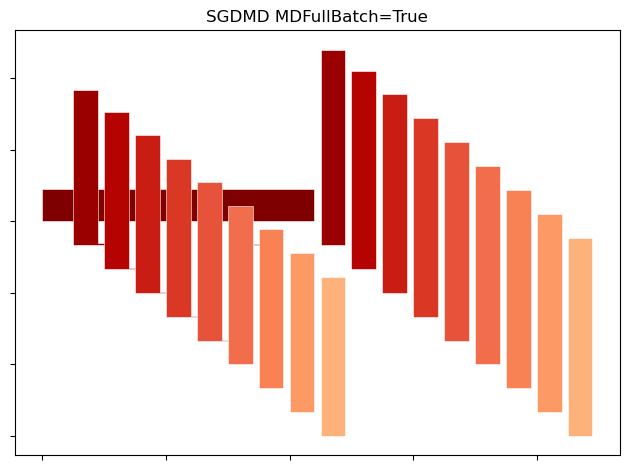

50


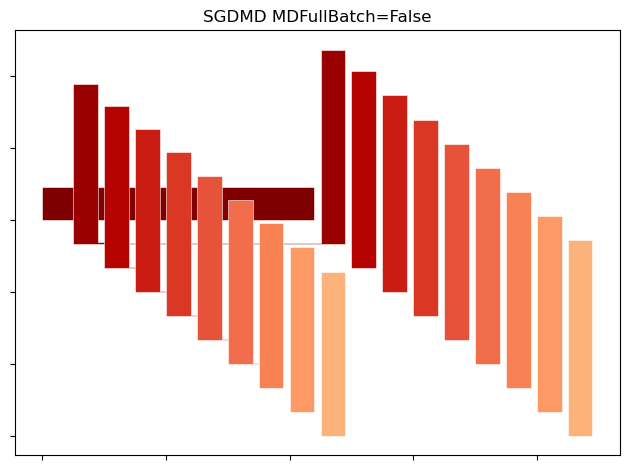

In [234]:
import numpy as np
import matplotlib.pyplot as plt


label_key = 'optimizer'
metric_key = 'weights'
client = MlflowClient(tracking_uri=tracking_uri)
e = client.get_experiment_by_name(experiment_name)

# query = "params.Title = ''"
runs = client.search_runs(experiment_ids=[e.experiment_id],
                          # filter_string=query,
                          filter_string='',
                          run_view_type=ViewType.ACTIVE_ONLY)

from matplotlib import cm
colors = cm.OrRd_r(np.linspace(.0, .6, 10))

optimizer_names = ['SGD']
for r in runs:
    config = mlflow.artifacts.load_dict(r.info.artifact_uri+'/config.json')

    if config[label_key]['name'] == 'SGD':
        continue

    if config['batch_size'] != 20:
        continue

    label = config[label_key]['name'] + ' ' + r.data.params['Title']
    i = config[label_key]['id'] + int(config['md_full'])
    weights = []
    for i in range(config['n_peers']):
        metric_key = 'weights_%s' % (str(i))
        history = client.get_metric_history(run_id=r.info.run_id, key=metric_key)
        y = np.array([h.value for h in history])
        # x = np.array([h.step for h in history])
        weights.append(y)
    weights = np.array(weights)
    print(len(weights.T))
    y = weights.T
    for j, i in enumerate(np.linspace(0, len(y)-1, 10, endpoint=True).round().astype(int)):
        bins, edges = y[i], np.linspace(0, len(y[i]), len(y[i])+1)

        left, right = edges[:-1], edges[1:]
        X = np.array([left, right]).T.flatten()
        Y = np.array([bins, bins]).T.flatten()

        x_shift = j * 1.25
        y_shift = -j/15
        plt.fill_between(X+x_shift, Y+y_shift, y_shift, facecolor = colors[j], linewidth=0.4, edgecolor='w')

    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    frame1.axes.yaxis.set_ticklabels([])

    # title = 'MNIST Log Reg'
    title = 'MNIST Log Reg | batch_size=' + str(config['batch_size'])
    title = config[label_key]['name'] + ' ' + r.data.params['Title']
    plt.title(title)
    plt.tight_layout()
    plt.show() 
    # break


